## Part 1

## Unzipping the dataset file

In [ ]:
import zipfile
import os

zip_path = 'cnn_dataset.zip'
extract_path = 'cnn_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully.")

Dataset unzipped successfully.


## Importing Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import time
import os
import h5py
from torchsummary import summary
from torchvision import transforms
from torch.utils import data
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from sklearn.preprocessing import normalize
from torchvision import transforms, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import torch.nn as nn
import random

In [ ]:
dataset_path = 'cnn_dataset'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

## Visualization

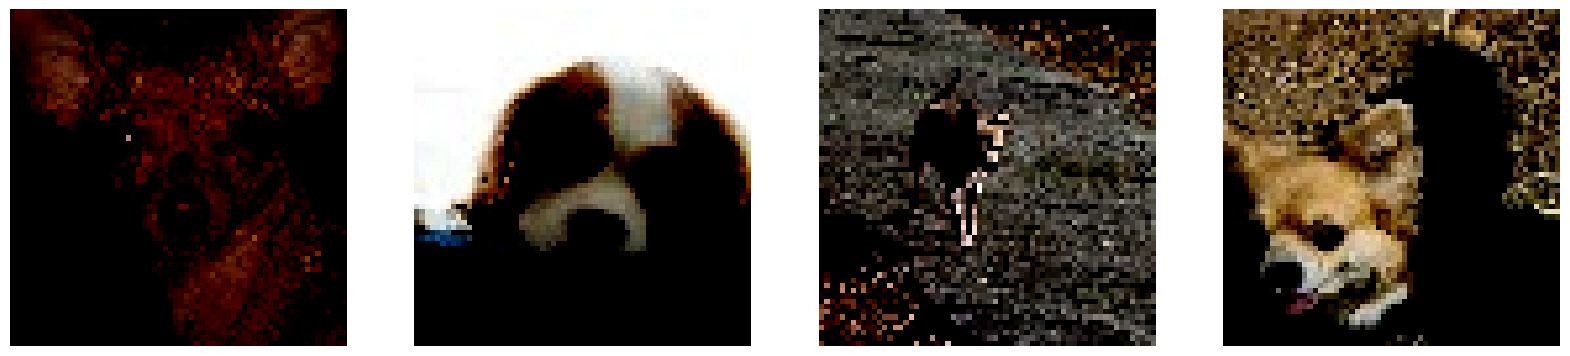

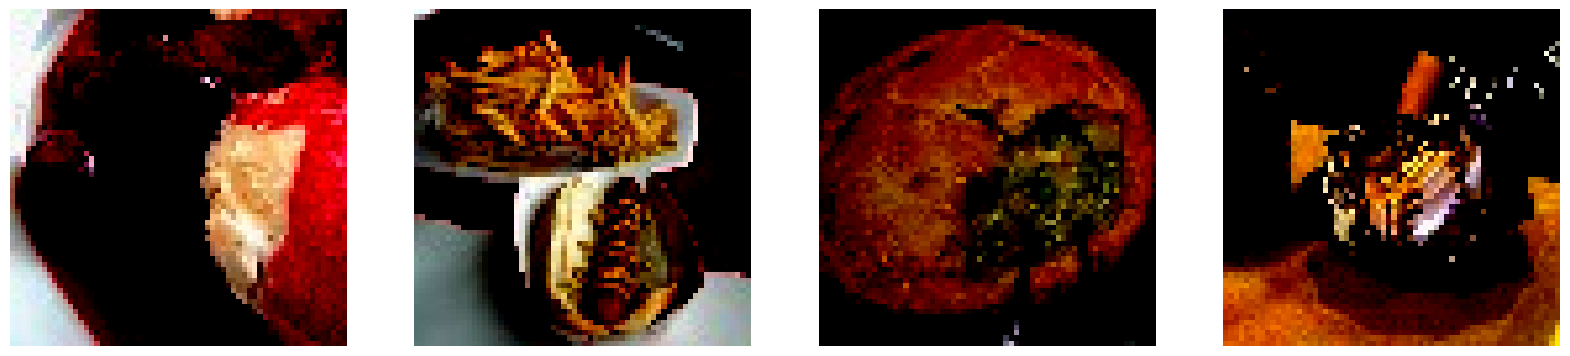

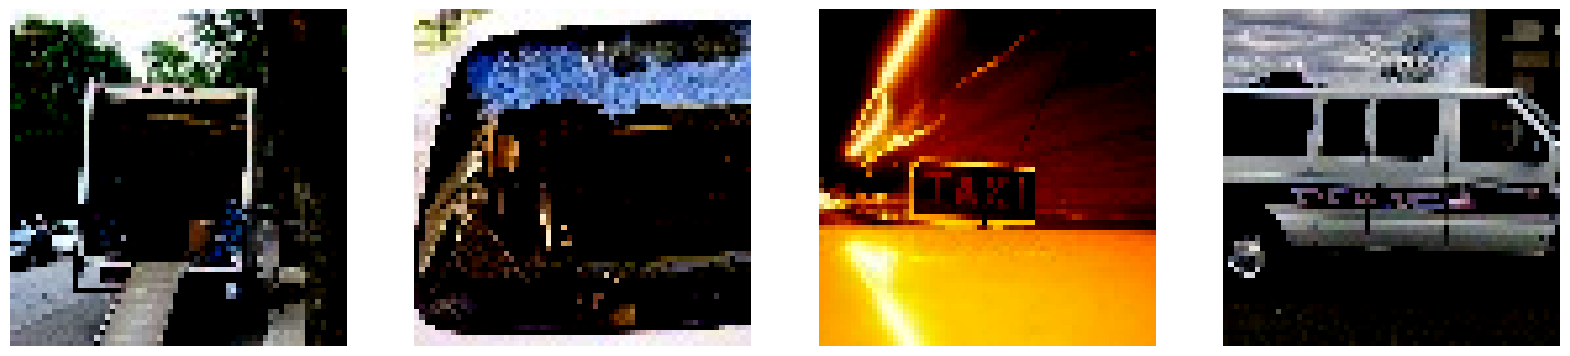

In [ ]:
def show_samples_per_class(dataset, num_classes, samples_per_class=4):
    class_indices = [[] for _ in range(num_classes)]


    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)


    for cls in range(num_classes):
        plt.figure(figsize=(5 * samples_per_class, 5))
        for i in range(samples_per_class):
            plt.subplot(1, samples_per_class, i + 1)
            idx = random.choice(class_indices[cls])
            image, label = dataset[idx]
            if image.shape[0] == 3:

                plt.imshow(image.permute(1, 2, 0))
            else:

                plt.imshow(image.squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()

show_samples_per_class(dataset, num_classes=3)

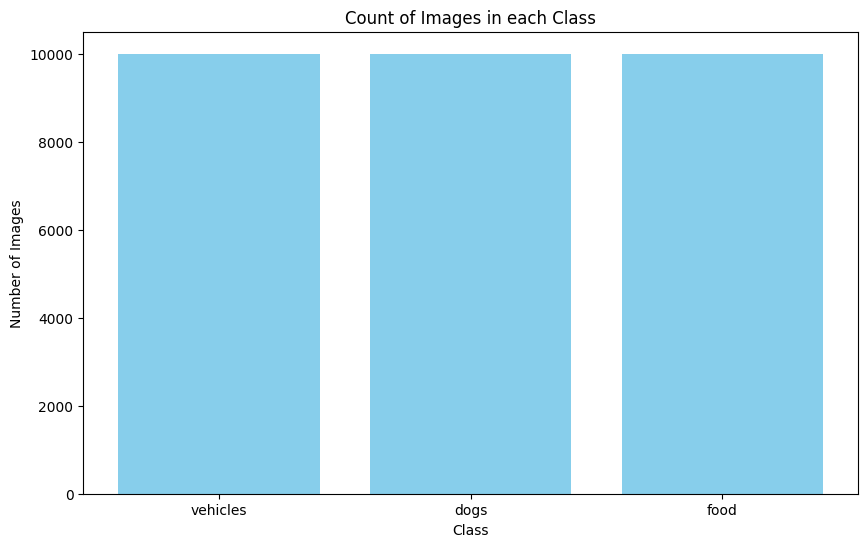

In [ ]:
lis = os.listdir(dataset_path)
dicti = {}
for i in lis:
    path_class = os.path.join(dataset_path, i)
    if os.path.isdir(path_class):
        num_images = len(os.listdir(path_class))
        dicti[i] = num_images

plt.figure(figsize=(10, 6))
plt.bar(dicti.keys(), dicti.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Count of Images in each Class')
plt.show()

## Split dataset

In [ ]:
num_classes = len(dataset.classes)
num_train = int(0.7 * len(dataset))
num_val = int(0.15 * len(dataset))
num_test = len(dataset) - num_train - num_val

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[num_train, num_val, num_test],
                                                        generator=torch.Generator().manual_seed(7))


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Number of classes in the dataset:", num_classes)
print("Length of dataset",len(dataset))
print("Length of train_size:", len(train_dataset))
print("Length of val_size:", len(val_dataset))
print("Length of test_size:", len(test_dataset))

Number of classes in the dataset: 3
Length of dataset 30000
Length of train_size: 21000
Length of val_size: 4500
Length of test_size: 4500


## VGG Model

In [ ]:
class VGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 2 * 2)
        x = self.classifier(x)
        return x

model = VGG13(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)
summary(model,input_size=(3,64,64))


VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

## Training and Validation

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = next(iter(train_loader))
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total +=  labels.size(0)
            correct +=  (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100*correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total +=  labels.size(0)
                correct +=  (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


Epoch: 1  Train Accuracy: 68.77%  Train Loss: 0.691079925168249  Validation Accuracy: 80.84%  Validation Loss: 0.4881036558621366
Epoch: 2  Train Accuracy: 84.33%  Train Loss: 0.4047852966560781  Validation Accuracy: 84.42%  Validation Loss: 0.4233081966218814
Epoch: 3  Train Accuracy: 87.05%  Train Loss: 0.3399949771745589  Validation Accuracy: 87.24%  Validation Loss: 0.3342709776381372
Epoch: 4  Train Accuracy: 88.54%  Train Loss: 0.3060797824096897  Validation Accuracy: 88.73%  Validation Loss: 0.31886092216615947
Epoch: 5  Train Accuracy: 89.90%  Train Loss: 0.26675599435270736  Validation Accuracy: 90.71%  Validation Loss: 0.25568500517959325


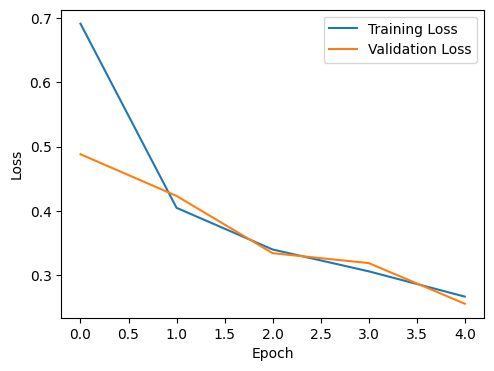

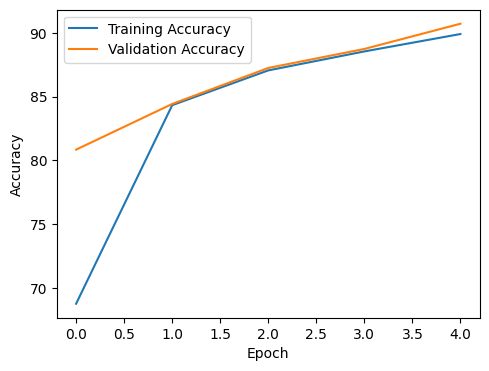

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

In [ ]:
#Test Accuracy and Loss
def test_accuracy(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy:', correct*100 // total,"%")
    print('Test Loss:', test_loss/len(test_loader))



In [ ]:
test_accuracy(model, test_loader)

Test Accuracy: 90 %
Test Loss: 0.2506405871728776


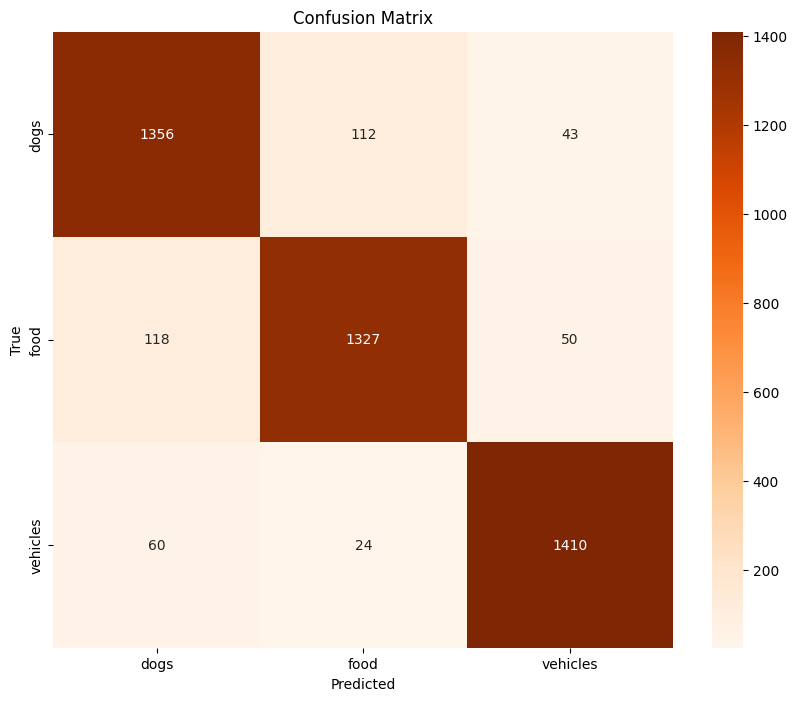

In [ ]:
#Confusion Matrix
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)

Precision: 0.91
Recall: 0.91
F1 Score: 0.91


## L2 Regularization

Epoch: 1  Train Accuracy: 91.74%  Train Loss: 0.22460503826387748  Validation Accuracy: 91.24%  Validation Loss: 0.24379048171177717
Epoch: 2  Train Accuracy: 92.72%  Train Loss: 0.19882743266668726  Validation Accuracy: 92.00%  Validation Loss: 0.22764003665094645
Epoch: 3  Train Accuracy: 93.30%  Train Loss: 0.19038854362754473  Validation Accuracy: 92.33%  Validation Loss: 0.22298689239041905
Epoch: 4  Train Accuracy: 93.64%  Train Loss: 0.17258994540590283  Validation Accuracy: 92.80%  Validation Loss: 0.21118331931426493
Epoch: 5  Train Accuracy: 94.84%  Train Loss: 0.14584316514817414  Validation Accuracy: 92.84%  Validation Loss: 0.21041207876003964
Test Accuracy: 92 %
Test Loss: 0.21717129311930966


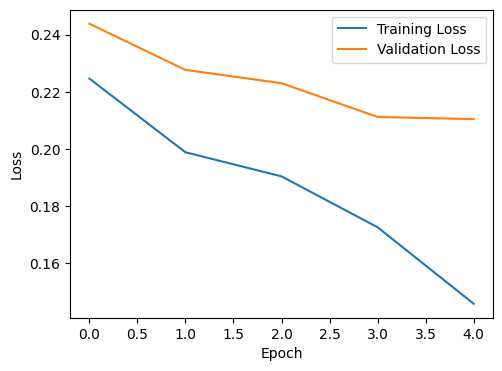

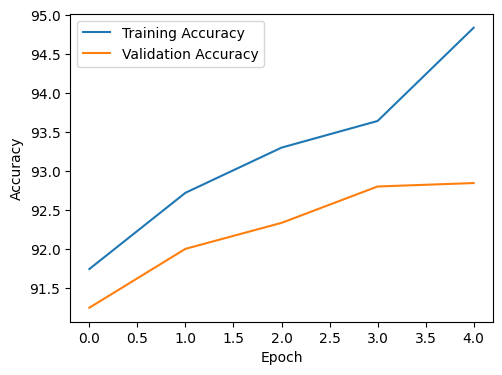

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# Training and Validation
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

#Test Accuracy and Loss
test_accuracy(model, test_loader)

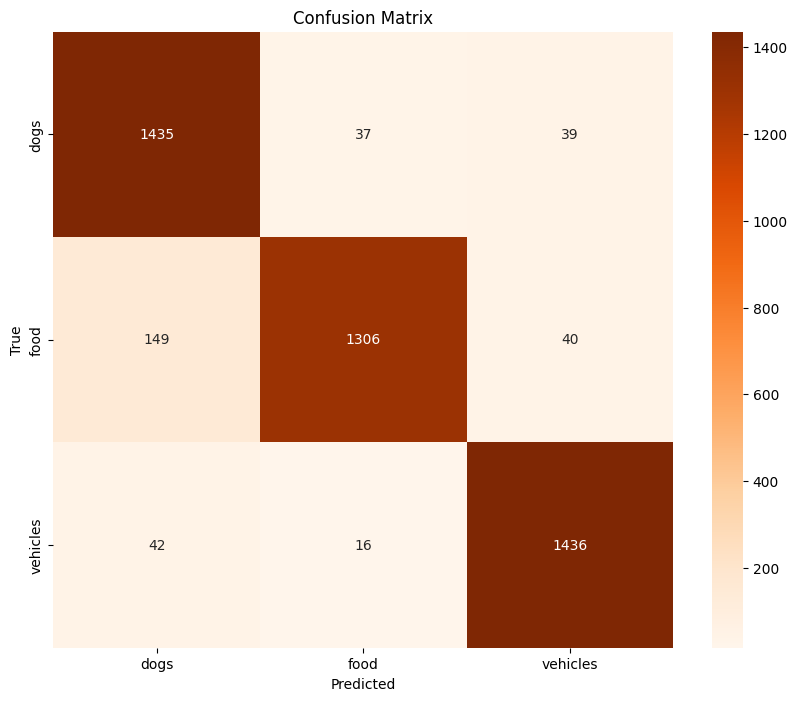

In [ ]:
#Confusion Matrix
y_true = []
y_pred = []
confusion_plot(model, test_loader)

In [ ]:
#Evlaution Metrics
metrics(y_true, y_pred)

Precision: 0.93
Recall: 0.93
F1 Score: 0.93


## Dropout

In [ ]:
#Model with dropout
class VGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 2 * 2)
        x = self.classifier(x)
        return x

model = VGG13(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)
summary(model,input_size=(3,64,64))

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

Epoch: 1  Train Accuracy: 68.80%  Train Loss: 0.6814285760411376  Validation Accuracy: 82.13%  Validation Loss: 0.4558902210752729
Epoch: 2  Train Accuracy: 84.42%  Train Loss: 0.40008015826480364  Validation Accuracy: 85.53%  Validation Loss: 0.38338555773379096
Epoch: 3  Train Accuracy: 87.11%  Train Loss: 0.34575909557313544  Validation Accuracy: 88.36%  Validation Loss: 0.32196184237238384
Epoch: 4  Train Accuracy: 88.73%  Train Loss: 0.3031768829173955  Validation Accuracy: 87.56%  Validation Loss: 0.31636395357864006
Epoch: 5  Train Accuracy: 90.26%  Train Loss: 0.26583194232186286  Validation Accuracy: 90.96%  Validation Loss: 0.250091327537953
Test Accuracy: 90 %
Test Loss: 0.24236288225986588


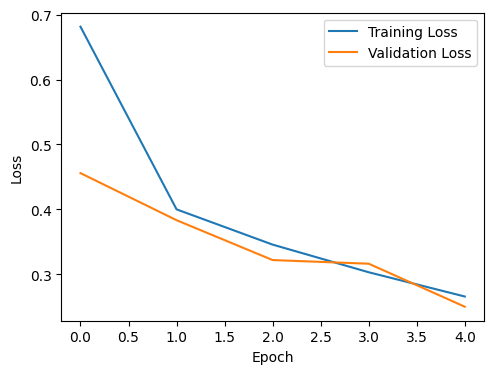

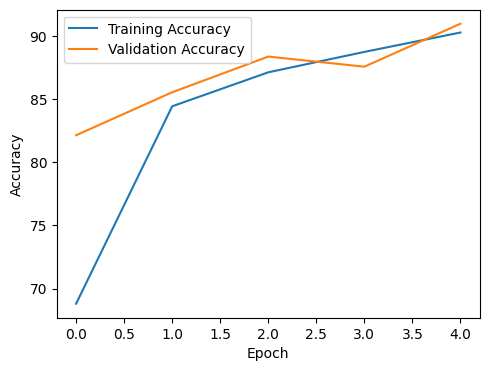

In [ ]:
#Training, Validaiton, Testing Accuracy and Loss
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)
test_accuracy(model, test_loader)

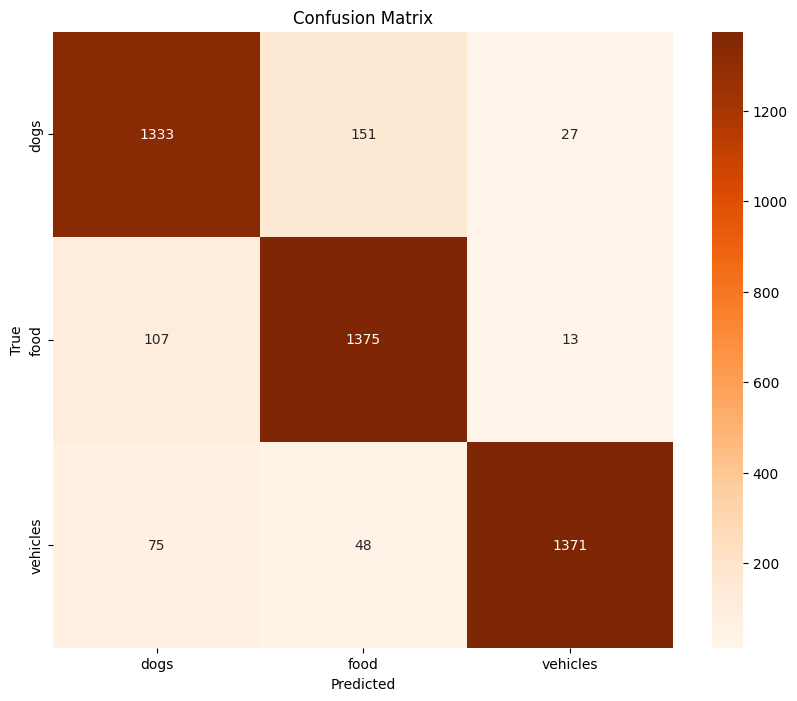

In [ ]:
#Confusion Matrix
y_true=[]
y_pred=[]
confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
metrics(y_true, y_pred)

Precision: 0.91
Recall: 0.91
F1 Score: 0.91


## Early Stopping

In [ ]:
#Training and Validation
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5, patience=5):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    early_stopping_counter = 0
    best_val_loss = np.inf

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1], ' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

        # Early stopping
        if val_loss / len(val_loader) < best_val_loss:
            best_val_loss = val_loss / len(val_loader)
            early_stopping_counter = 0  # Reset counter
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered. Stopping training after {epoch+1} epochs.")
                break  # Stop training

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Epoch: 1  Train Accuracy: 91.20%  Train Loss: 0.24038546530127888  Validation Accuracy: 91.49%  Validation Loss: 0.2288466441169591
Epoch: 2  Train Accuracy: 92.17%  Train Loss: 0.21511746906763152  Validation Accuracy: 92.36%  Validation Loss: 0.2213013430296535
Epoch: 3  Train Accuracy: 92.71%  Train Loss: 0.1987156103333985  Validation Accuracy: 88.76%  Validation Loss: 0.28624408461258444
Epoch: 4  Train Accuracy: 93.14%  Train Loss: 0.18643819797772768  Validation Accuracy: 91.00%  Validation Loss: 0.26279083387532703
Epoch: 5  Train Accuracy: 93.87%  Train Loss: 0.16805452030820145  Validation Accuracy: 91.89%  Validation Loss: 0.246766897994028


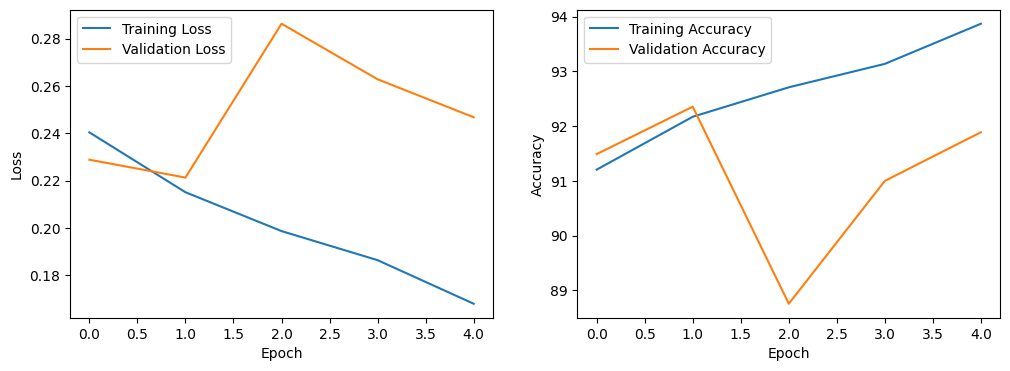

Test Accuracy: 91 %
Test Loss: 0.24602335387132537


In [ ]:
#Training, Validaiton, Testing Accuracy and Loss
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)
test_accuracy(model, test_loader)

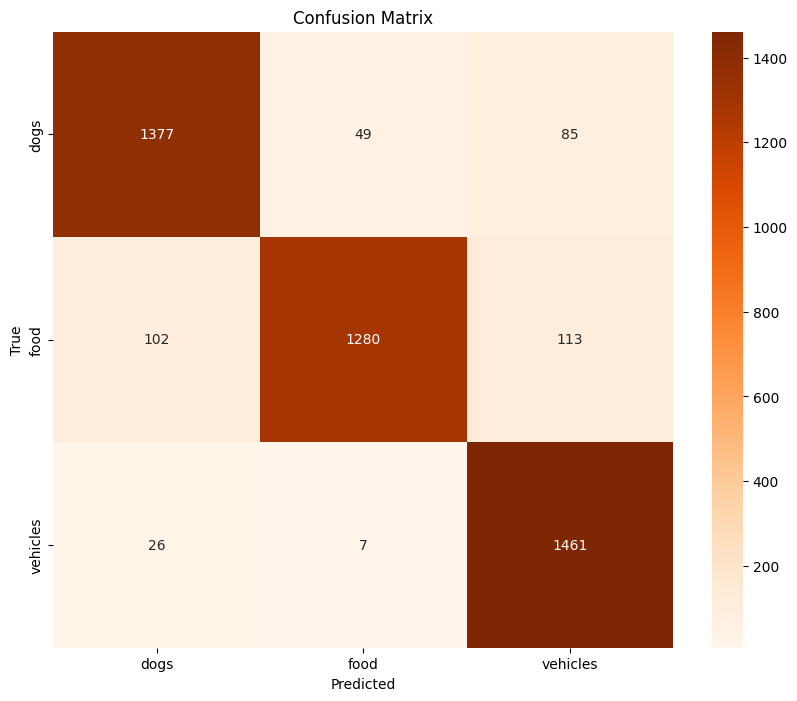

In [ ]:
#Confusion Matrix
y_true=[]
y_pred=[]
confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
metrics(y_true, y_pred)

Precision: 0.92
Recall: 0.92
F1 Score: 0.91


## Image Augmentation

In [ ]:
transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset_aug = datasets.ImageFolder(root=dataset_path, transform=transform_aug)

num_train = int(0.7 * len(dataset_aug))
num_val = int(0.15 * len(dataset_aug))
num_test = len(dataset_aug) - num_train - num_val

train_aug_dataset, val_aug_dataset, test_aug_dataset = random_split(dataset_aug, lengths=[num_train, num_val, num_test], generator=torch.Generator().manual_seed(7))



In [ ]:
train_aug_loader = DataLoader(train_aug_dataset, batch_size=64, shuffle=True, drop_last=True)
val_aug_loader = DataLoader(val_aug_dataset, batch_size=64, shuffle=False, drop_last=True)
test_aug_loader = DataLoader(test_aug_dataset, batch_size=64, shuffle=False, drop_last=True)

Epoch: 1  Train Accuracy: 92.25%  Train Loss: 0.2074729356937474  Validation Accuracy: 92.05%  Validation Loss: 0.22223327245031085
Epoch: 2  Train Accuracy: 92.96%  Train Loss: 0.18553580897973804  Validation Accuracy: 92.86%  Validation Loss: 0.19741437302104065
Epoch: 3  Train Accuracy: 93.09%  Train Loss: 0.18899852359985433  Validation Accuracy: 92.95%  Validation Loss: 0.20026441599641528
Epoch: 4  Train Accuracy: 93.98%  Train Loss: 0.16519895911489318  Validation Accuracy: 93.21%  Validation Loss: 0.19018026930945262
Epoch: 5  Train Accuracy: 94.28%  Train Loss: 0.15755091370764848  Validation Accuracy: 93.55%  Validation Loss: 0.18443972798330444


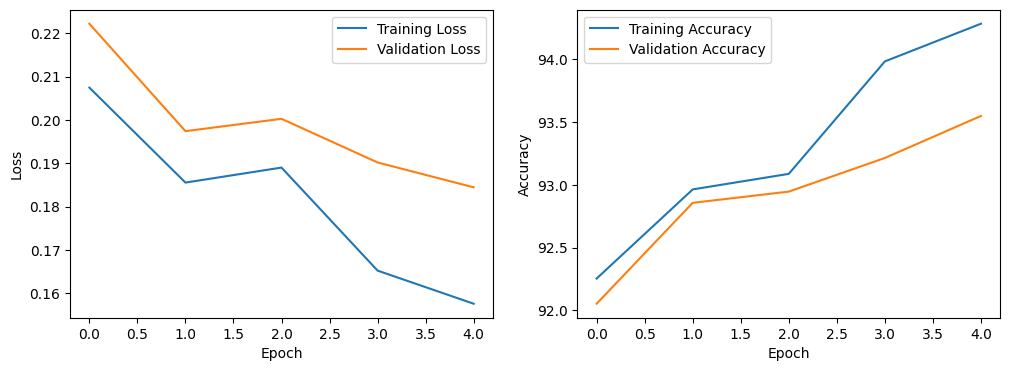

Test Accuracy: 93 %
Test Loss: 0.18524887556476252


In [ ]:
#Training, Validaiton, Testing Accuracy and Loss
train_and_validate(model, train_aug_loader, val_aug_loader, optimizer, criterion, epochs=5)
test_accuracy(model, test_aug_loader)

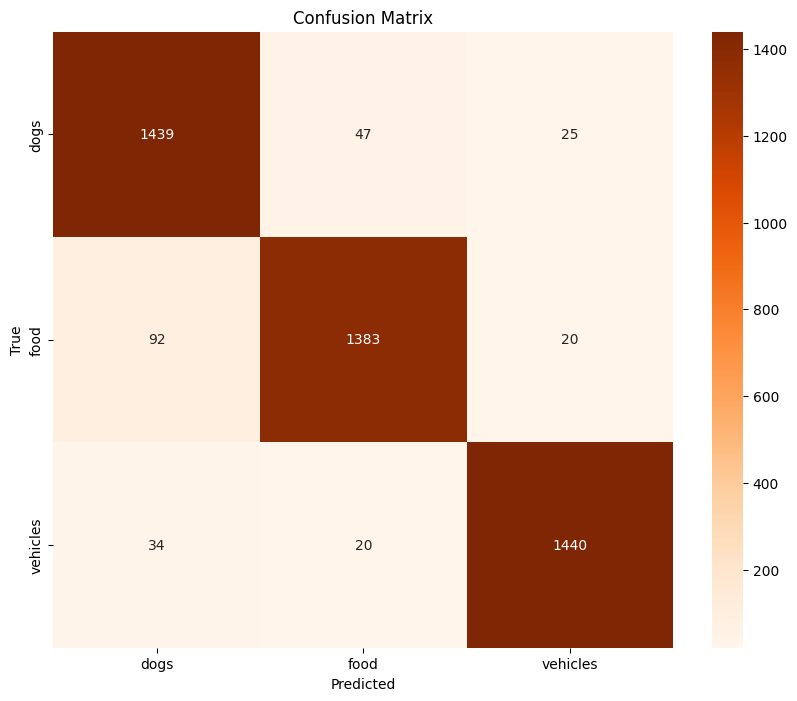

In [ ]:
#Confusion Matrix
y_true=[]
y_pred=[]
confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
metrics(y_true, y_pred)

Precision: 0.95
Recall: 0.95
F1 Score: 0.95


In [ ]:
torch.save(model.state_dict(), 'VGG_Model.h5')

## References

1. https://arxiv.org/abs/1409.1556
2. https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
3. https://en.wikipedia.org/wiki/Early_stopping
4. https://pytorch.org/vision/stable/transforms.html
5. CSE 574 Machine Learning Assignment 2 submission by Dharma. Acha
6. https://pandas.pydata.org/
7. https://pytorch.org/vision/stable/models.html